## mock_manga
- This script checks the consistency for the mock MaNGA sample (wrt the real sample).
- using $\mathrm{j_{stellar}}$ is difficult since it is heavily biased by the number of particles.

In [27]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import kin_morph_funcs as knf
from astropy.cosmology import Planck15
from scipy import interpolate
import scipy.stats as stats
import scipy
import spin_bias_funcs as sbf
import spin_bias_tng_funcs as sbtf
import seaborn as sns
import imp
imp.reload(sbtf)
from matplotlib import rcParams
sbf.plot_default(rcParams)

In [2]:
# defining paths
inpath = '/Users/chrisduckworth/astronomy/projects/spin_bias/catalogues/'
outpath = '/Users/chrisduckworth/astronomy/projects/spin_bias/plots/tng_comparison/'

In [47]:
# Loading in TNG100 sample with z=0 info to select samples.
tng100_main = pd.read_csv(inpath + 'tng100_mpl8_pa_info_v0.1_z0_info.csv', comment='#')
tng100_pa = knf.tng100_pa_sample(tng100_main)

# matching to angular momentum table because lambda_r measure in table is pretty bad.
ang_tab = pd.read_csv(inpath + 'tng_mpl8_ang_mom_history.csv')
ang_subsample = ang_tab[ang_tab.root_subfind.isin(tng100_pa.subfind_id.values)]
ang_z0 = ang_subsample[ang_subsample.branch_snapnum.values == 99]

# merging the two tables together
matched = tng100_pa.merge(ang_z0, left_on="subfind_id", right_on="root_subfind")

# adding additional stel to halo mass ratio column.
matched['stellar_to_halo_ratio'] = matched.stel_mass.values / matched.halo_mass.values

# Breaking down morphology (deviations from sfms).
QU, SF, GV = knf.SFMS_breakdown(matched)

all_spirals = pd.concat([SF, GV])
all_early = pd.concat([QU, GV])

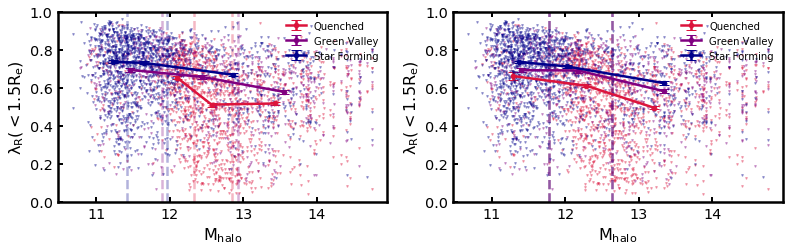

In [52]:
fig, ax = plt.subplots(1,2, figsize=(13, 3.5))

# finding 33 percentiles for individual populations.
sbtf.plot_lambdaR_mhalo_single_population(QU, ax[0], color='crimson', label='Quenched')
sbtf.plot_lambdaR_mhalo_single_population(GV, ax[0], color='purple', label='Green Valley')
sbtf.plot_lambdaR_mhalo_single_population(SF, ax[0], color='darkblue', label='Star Forming')
ax[0].legend(frameon=False, loc='upper right')

# finding 33 mass percentiles for overall population.
upper = np.log10(np.percentile(matched.halo_mass.values, 66))
lower = np.log10(np.percentile(matched.halo_mass.values, 33))

sbtf.plot_lambdaR_mhalo_single_population(QU, ax[1], color='crimson', lower=lower, upper=upper, label='Quenched')
sbtf.plot_lambdaR_mhalo_single_population(GV, ax[1], color='purple', lower=lower, upper=upper, label='Green Valley')
sbtf.plot_lambdaR_mhalo_single_population(SF, ax[1], color='darkblue', lower=lower, upper=upper, label='Star Forming')
ax[1].legend(frameon=False, loc='upper right')
plt.savefig(outpath+'tng_lambdaR_mhalo_morphology_split.pdf', format='pdf', bbox_inches='tight')


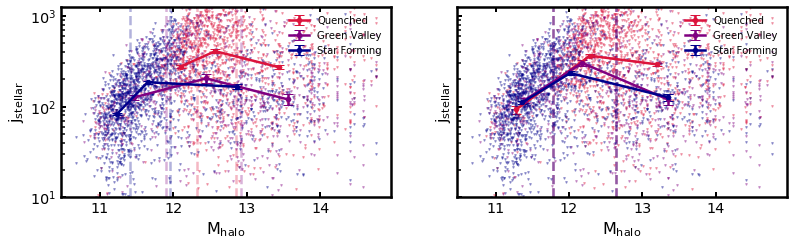

In [53]:
fig, ax = plt.subplots(1,2, figsize=(13, 3.5), sharey='all')

# finding 33 percentiles for individual populations.
sbtf.plot_sJ_mhalo_single_population(QU, ax[0], color='crimson', label='Quenched')
sbtf.plot_sJ_mhalo_single_population(GV, ax[0], color='purple', label='Green Valley')
sbtf.plot_sJ_mhalo_single_population(SF, ax[0], color='darkblue', label='Star Forming')
ax[0].legend(frameon=False, loc='upper right')

# finding 33 mass percentiles for overall population.
upper = np.log10(np.percentile(matched.halo_mass.values, 66))
lower = np.log10(np.percentile(matched.halo_mass.values, 33))

sbtf.plot_sJ_mhalo_single_population(QU, ax[1], color='crimson', lower=lower, upper=upper, label='Quenched')
sbtf.plot_sJ_mhalo_single_population(GV, ax[1], color='purple', lower=lower, upper=upper, label='Green Valley')
sbtf.plot_sJ_mhalo_single_population(SF, ax[1], color='darkblue', lower=lower, upper=upper, label='Star Forming')
ax[1].legend(frameon=False, loc='upper right')
ax[0].set_yscale('log')
ax[0].set_ylim([10, 10**3.1])
plt.savefig(outpath+'tng_sJstel_mhalo_morphology_split.pdf', format='pdf', bbox_inches='tight')


### recreating the lambda_R vs Mhalo split on morphology.

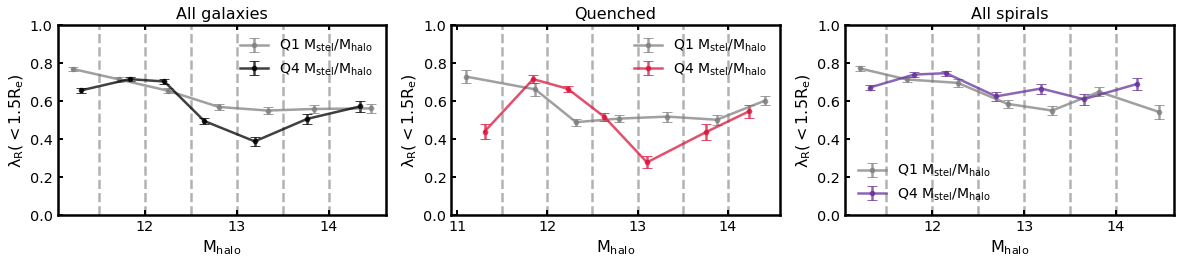

In [54]:
plt.cla()
plt.close('all')
fig, ax = plt.subplots(1, 3, figsize=(20, 3.5))

## all galaxies.
x_bins = np.array([11.5, 12, 12.5, 13, 13.5, 14]) 
x_quantity = np.log10(matched.halo_mass.values)
z_quantity = matched.stellar_to_halo_ratio.values
z_percentiles = np.array([25, 50, 75])
y_quantity = matched.lambda_r.values

sbf.binned_percentiles_three_props(x_quantity, y_quantity, z_quantity, x_bins, z_percentiles, 
                                   ['Q1 $\mathrm{M_{stel}/M_{halo}}$', 'mid low', 'mid high', 'Q4 $\mathrm{M_{stel}/M_{halo}}$'], 
                                   ax[0], colors=['grey', 'dodgerblue', 'slateblue', 'k'], extrema=True)

for x in x_bins:
    ax[0].axvline(x, color='k', alpha=0.3, linestyle='dashed')

ax[0].legend(frameon=False, fontsize=14)
ax[0].set_ylim([0, 1])
ax[0].set_ylabel(r'$\mathrm{\lambda_{R}(< 1.5R_{e})}$', fontsize=16)
ax[0].set_xlabel(r'$\mathrm{M_{halo}}$', fontsize=16)
ax[0].set_title('All galaxies', fontsize=16) 

## etgs
x_bins = np.array([11.5, 12, 12.5, 13, 13.5, 14]) 
x_quantity = np.log10(QU.halo_mass.values)
z_quantity = QU.stellar_to_halo_ratio.values
z_percentiles = np.array([25, 50, 75])
y_quantity = QU.lambda_r.values

sbf.binned_percentiles_three_props(x_quantity, y_quantity, z_quantity, x_bins, z_percentiles, 
                                   ['Q1 $\mathrm{M_{stel}/M_{halo}}$', 'mid low', 'mid high', 'Q4 $\mathrm{M_{stel}/M_{halo}}$'], 
                                   ax[1], colors=['grey', 'dodgerblue', 'slateblue', 'crimson'], extrema=True)

for x in x_bins:
    ax[1].axvline(x, color='k', alpha=0.3, linestyle='dashed')

ax[1].legend(frameon=False, fontsize=14)
ax[1].set_ylim([0, 1])
ax[1].set_ylabel(r'$\mathrm{\lambda_{R}(< 1.5R_{e})}$', fontsize=16)
ax[1].set_xlabel(r'$\mathrm{M_{halo}}$', fontsize=16)
ax[1].set_title('Quenched', fontsize=16) 

## Star forming and Quenched
x_bins = np.array([11.5, 12, 12.5, 13, 13.5, 14]) 
x_quantity = np.log10(all_spirals.halo_mass.values)
z_quantity = all_spirals.stellar_to_halo_ratio.values
z_percentiles = np.array([25, 50, 75])
y_quantity = all_spirals.lambda_r.values

sbf.binned_percentiles_three_props(x_quantity, y_quantity, z_quantity, x_bins, z_percentiles, 
                                   ['Q1 $\mathrm{M_{stel}/M_{halo}}$', 'mid low', 'mid high', 'Q4 $\mathrm{M_{stel}/M_{halo}}$'], 
                                   ax[2], colors=['grey', 'dodgerblue', 'slateblue', 'rebeccapurple'], extrema=True)

for x in x_bins:
    ax[2].axvline(x, color='k', alpha=0.3, linestyle='dashed')

ax[2].legend(frameon=False, fontsize=14)
ax[2].set_ylim([0, 1])
ax[2].set_ylabel(r'$\mathrm{\lambda_{R}(< 1.5R_{e})}$', fontsize=16)
ax[2].set_xlabel(r'$\mathrm{M_{halo}}$', fontsize=16)
ax[2].set_title('All spirals', fontsize=16) 
plt.savefig(outpath+'tng_lambdaR_mhalo_ratio_all.pdf', format='pdf', bbox_inches='tight')


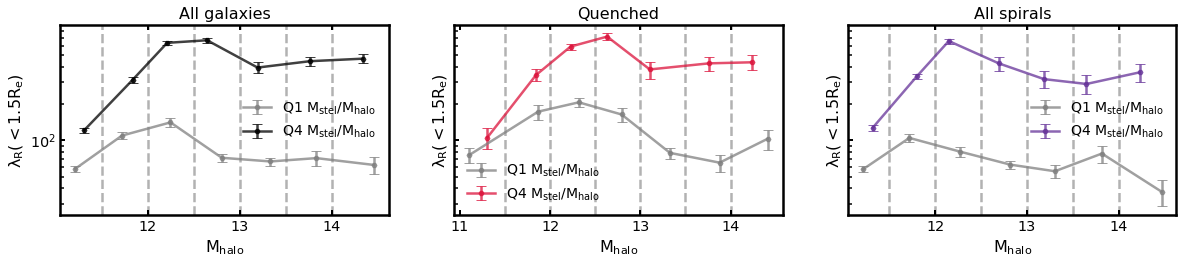

In [55]:
plt.cla()
plt.close('all')
fig, ax = plt.subplots(1, 3, figsize=(20, 3.5), sharey='all')

## all galaxies.
x_bins = np.array([11.5, 12, 12.5, 13, 13.5, 14]) 
x_quantity = np.log10(matched.halo_mass.values)
z_quantity = matched.stellar_to_halo_ratio.values
z_percentiles = np.array([25, 50, 75])
y_quantity = matched.mag_sJ_stel.values

sbf.binned_percentiles_three_props(x_quantity, y_quantity, z_quantity, x_bins, z_percentiles, 
                                   ['Q1 $\mathrm{M_{stel}/M_{halo}}$', 'mid low', 'mid high', 'Q4 $\mathrm{M_{stel}/M_{halo}}$'], 
                                   ax[0], colors=['grey', 'dodgerblue', 'slateblue', 'k'], extrema=True)

for x in x_bins:
    ax[0].axvline(x, color='k', alpha=0.3, linestyle='dashed')

ax[0].legend(frameon=False, fontsize=14)
ax[0].set_ylabel(r'$\mathrm{\lambda_{R}(< 1.5R_{e})}$', fontsize=16)
ax[0].set_xlabel(r'$\mathrm{M_{halo}}$', fontsize=16)
ax[0].set_title('All galaxies', fontsize=16) 

## etgs
x_bins = np.array([11.5, 12, 12.5, 13, 13.5, 14]) 
x_quantity = np.log10(QU.halo_mass.values)
z_quantity = QU.stellar_to_halo_ratio.values
z_percentiles = np.array([25, 50, 75])
y_quantity = QU.mag_sJ_stel.values

sbf.binned_percentiles_three_props(x_quantity, y_quantity, z_quantity, x_bins, z_percentiles, 
                                   ['Q1 $\mathrm{M_{stel}/M_{halo}}$', 'mid low', 'mid high', 'Q4 $\mathrm{M_{stel}/M_{halo}}$'], 
                                   ax[1], colors=['grey', 'dodgerblue', 'slateblue', 'crimson'], extrema=True)

for x in x_bins:
    ax[1].axvline(x, color='k', alpha=0.3, linestyle='dashed')

ax[1].legend(frameon=False, fontsize=14)
ax[1].set_ylabel(r'$\mathrm{\lambda_{R}(< 1.5R_{e})}$', fontsize=16)
ax[1].set_xlabel(r'$\mathrm{M_{halo}}$', fontsize=16)
ax[1].set_title('Quenched', fontsize=16) 

## Star forming and Quenched
x_bins = np.array([11.5, 12, 12.5, 13, 13.5, 14]) 
x_quantity = np.log10(all_spirals.halo_mass.values)
z_quantity = all_spirals.stellar_to_halo_ratio.values
z_percentiles = np.array([25, 50, 75])
y_quantity = all_spirals.mag_sJ_stel.values

sbf.binned_percentiles_three_props(x_quantity, y_quantity, z_quantity, x_bins, z_percentiles, 
                                   ['Q1 $\mathrm{M_{stel}/M_{halo}}$', 'mid low', 'mid high', 'Q4 $\mathrm{M_{stel}/M_{halo}}$'], 
                                   ax[2], colors=['grey', 'dodgerblue', 'slateblue', 'rebeccapurple'], extrema=True)

for x in x_bins:
    ax[2].axvline(x, color='k', alpha=0.3, linestyle='dashed')

ax[2].legend(frameon=False, fontsize=14)
ax[2].set_ylabel(r'$\mathrm{\lambda_{R}(< 1.5R_{e})}$', fontsize=16)
ax[2].set_xlabel(r'$\mathrm{M_{halo}}$', fontsize=16)
ax[2].set_title('All spirals', fontsize=16) 
ax[2].set_yscale('log')
plt.savefig(outpath+'tng_sJstel_mhalo_ratio_all.pdf', format='pdf', bbox_inches='tight')
